# Final modelling notebooks

This is the final notebook with all the models explained. We will make 2 different approachs:
- Using only the features extracted on **final_notebook_feature_extraction**
- Using the features extracted + features extracted with TFIDF transformation

We will use 5 different types of machine learning models, on some of them we will apply GridSearch CV:
- Logistic regression as benchmark for first aproach
- Passive aggressive classifier as benchmark for second aproach
- K-nearest Neighbour
- Decision Tree
- Random Forest
- XGBoost

And we are using the following metrics to evaluate the model:
- Classification accuracy
- Logarithmic loss
- Confusion matrix
- Recall or sensitivity
- Specifity
- Area under curve (AUC)
- F1 Score

# Index

- [1. Evaluation metrics explanined](#1.-Evaluation-metrics-explained)
- [2. Evaluation functions] (#2.-Evaluation-functions)
- [3. First approach: Only features extracted](#3.-First-approach:-Only-features-extracted)
    - Logistic regression as benchmark for first aproach
    - K-nearest Neighbour
    - Decision Tree
    - Random Forest
    - XGBoost
- [4. Second approach: TFIDF Transformation + features](#4.-Second-approach:-TFIDF-Transformation-+-features)
    - [TFIDF Transformation](#TFIDF-Transformation)
    - [Passive aggressive classifier as benchmark for second aproach](#4.1.-Passive-Aggressive-Classifier-(Only-TFIDF-features))
    - K-nearest Neighbour
    - Decision Tree
    - Random Forest
    - XGBoost
- 5. Choose the best model
- 6. Pickle the best model

# 1. Evaluation metrics explained

### Classification accuracy

Classification Accuracy is what we usually mean, when we use the term accuracy. It is the ratio of number of correct predictions (True Positives + True Negatives) to the total number of input samples:

$$Accuracy = \frac{True Positives + True Negatives}{TotalExamples}$$

### Logarithmic loss
Logarithmic Loss or Log Loss, works by penalising the false classifications. It works well for multi-class classification. When working with Log Loss, the classifier must assign probability to each class for all the samples. Suppose, there are N samples belonging to M classes, then the Log Loss is calculated as below :

$$Logarithmic Loss = \frac{-1}{N}\sum\limits_{i=1}^{N}\sum\limits_{j=1}^{M} y_{i_j} \times log(p_{i_j})$$

### Confusion Matrix
A confusion matrix is a matrix representation of the prediction results of any binary testing that is often used to describe the performance of the classification model (or “classifier”) on a set of test data for which the true values are known.

![ConfusionMatrix](../imgs/ConfusionMatrix.png)

Important terms:

- True Positives : The cases in which we predicted YES and the actual output was also YES.
- True Negatives : The cases in which we predicted NO and the actual output was NO.
- False Positives : The cases in which we predicted YES and the actual output was NO.
- False Negatives : The cases in which we predicted NO and the actual output was YES.

### Recall or Sensitivity
Recall or Sensitivity gives us the True Positive Rate (TPR), which is defined as TP / (FN+TP). True Positive Rate corresponds to the proportion of positive data points that are correctly considered as positive, with respect to all positive data points.

![ConfusionMatrixSensitivity](../imgs/ConfusionMatrixSensitivity.png)

$$True Positive Rate = \frac{True Positive}{False Negative + True Positive}$$
                                                                       
### Specifity
Specifity gives us the True Negative Rate (TNR), which is defined as TN / (FP+TN). False Positive Rate corresponds to the proportion of negative data points that are correctly considered as negative, with respect to all negative data points.

![ConfusionMatrixSpecifity](../imgs/ConfusionMatrixSpecifity.png)

$$True Negative Rate = \frac{True Negative}{True Negative Negative + False Positive}$$


### Area under curve (AUC)
Area Under Curve(AUC) is one of the most widely used metrics for evaluation. It is used for binary classification problem. AUC of a classifier is equal to the probability that the classifier will rank a randomly chosen positive example higher than a randomly chosen negative example.

### Precision
Precision is the number of correct positive results divided by the number of positive results predicted by the classifier.

$$Precision = \frac{True Positives}{True Positives + False Positives}$$


### F1 Score
F1 Score is used to measure a test's accuracy. F1 Score is the Harmonic Mean between precision and recall. The range for F1 Score is [0, 1]. It tells you how precise your classifier is (how many instances it classifies correctly), as well as how robust it is (it does not miss a significant number of instances).

High precision but lower recall, gives you an extremely accurate, but it then misses a large number of instances that are difficult to classify. The greater the F1 Score, the better is the performance of our model. Mathematically, it can be expressed as :

$$F1 = 2 \times \frac{1}{\frac{1}{precision} + \frac{1}{recall}}$$

F1 Score tries to find the balance between precision and recall.

# 2. Evaluation functions

## ROC AUC curve

In [84]:
def prediction_results(model, y_test, X_test, y_pred, probs):
    
    # testing AUC
    auc = roc_auc_score(y_test, probs)
    print('Testing AUC score: %.2f' % auc)

    # accuracy score and log loss
    print('Logloss: %.2f' % (log_loss(y_test, y_pred)))
    print('Accuracy: %.2f' % (model.score(X_test, y_test) * 100))

    # roc curve calculation
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)

    # plot the roc curve
    plt.plot(false_positive_rate, true_positive_rate, marker = ',')
    
    # no skill limits
    plt.plot([0, 1], [0, 1], linestyle = '--')
    
    plt.title('Receiver Operating Characteristic Curve \n', fontsize = 16)
    plt.xlabel('\n False Positive Rate (FPR)', fontsize = 13)
    plt.ylabel('Sensitivity/ Recall (TTR) \n', fontsize = 13)
    plt.legend(["AUC = %.2f"%auc])
    plt.show();

## Confusion matrix

In [85]:
def plot_confusion_matrix(y_test, y_pred):
    
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    fig, ax = plt.subplots(figsize = (7, 5.5))
    sns.heatmap(cf_matrix, annot = labels, ax = ax, fmt = '',cmap = 'Blues', annot_kws = {"size": 13})

    # Labels, title and ticks
    label_font = {'size':'15'}  
    ax.set_xlabel(' \n Predicted values', fontdict = label_font);
    ax.set_ylabel('Actual values \n', fontdict = label_font);

    title_font = {'size':'16'}  # 
    ax.set_title('Confusion Matrix \n', fontdict = title_font);

    ax.tick_params(axis = 'both', which = 'major', labelsize = 13) 
    ax.xaxis.set_ticklabels(['Fake', 'Real']);
    ax.yaxis.set_ticklabels(['Fake', 'Real']);
    plt.show()

# 3. First approach: Only features extracted

In [86]:
import pandas as pd
pd.options.display.max_columns = None

df = pd.read_csv('../data/spanish_corpus_features_v6.csv')
df.head()

,topic,text,headline,words_h,word_size_h,avg_syllables_word_h,unique_words_h,ttr_h,mltd_h,sents,words,avg_words_sent,avg_word_size,avg_syllables_word,unique_words,ttr,mltd,huerta_score,szigriszt_score,upper_case_ratio,entity_ratio,quotes,quotes_ratio,propn_ratio,noun_ratio,adp_ratio,det_ratio,punct_ratio,pron_ratio,verb_ratio,adv_ratio,sym_ratio,label
0,Science,la nasa recupera el contacto con un satélite d...,la nasa recupera el contacto con un satélite d...,16,5.38,2.50,87.50,93.75,71.68,16,479,29.94,4.76,2.04,32.99,44.68,57.42,53.90,49.96,3.87,4.59,0,0.00,5.85,22.96,17.75,15.66,7.10,1.67,8.56,3.76,0.00,1
1,Economy,amlo aceleraría el consumo y el crecimiento ec...,amlo aceleraría el consumo y el crecimiento ec...,11,5.27,2.55,81.82,90.91,33.88,5,206,41.20,4.58,1.89,35.44,50.97,63.55,51.42,47.69,4.35,6.31,2,0.97,9.22,22.82,15.53,16.50,11.17,0.49,6.31,0.97,0.00,1
2,Sport,al borde de un colapso nervioso quedó el hábil...,compañero de james se ‘calvea’ y le juega pesa...,12,3.75,1.67,100.00,100.00,0.00,13,368,28.31,4.23,1.70,44.02,54.89,67.43,75.96,72.72,2.60,5.16,8,2.17,7.88,16.03,15.22,13.32,13.32,4.35,8.15,3.53,0.54,0
3,Politics,"mediante pupitrazo de último minuto anoche, el...",dian gravará este año a los niños que recojan ...,12,4.58,1.92,100.00,100.00,0.00,8,269,33.62,4.75,1.92,40.89,54.65,65.30,57.35,53.71,2.02,3.35,4,1.49,3.72,21.56,19.33,15.24,10.04,0.74,6.69,3.35,0.00,0
4,Politics,muy temprano esta mañana el expresidente y aho...,uribe asegura que insultó 358 guerrilleros,6,6.17,2.50,100.00,100.00,0.00,9,260,28.89,4.18,1.59,50.38,61.92,93.74,81.97,78.75,1.81,3.85,7,2.69,7.31,15.77,8.46,10.77,20.00,5.38,10.38,5.00,0.77,0


In [87]:
df.shape

(3974, 33)

In [88]:
df.columns

Index(['topic', 'text', 'headline', 'words_h', 'word_size_h',
       'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 'sents',
       'words', 'avg_words_sent', 'avg_word_size', 'avg_syllables_word',
       'unique_words', 'ttr', 'mltd', 'huerta_score', 'szigriszt_score',
       'upper_case_ratio', 'entity_ratio', 'quotes', 'quotes_ratio',
       'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio',
       'pron_ratio', 'verb_ratio', 'adv_ratio', 'sym_ratio', 'label'],
      dtype='object')

## 2.1. Logistic regression

Testing AUC score: 0.96
Logloss: 3.42
Accuracy: 90.11


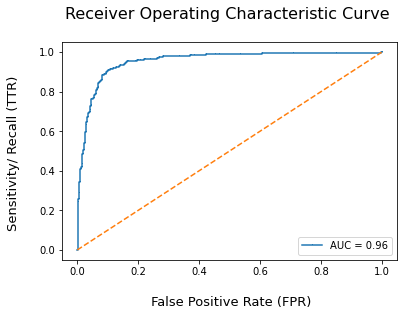

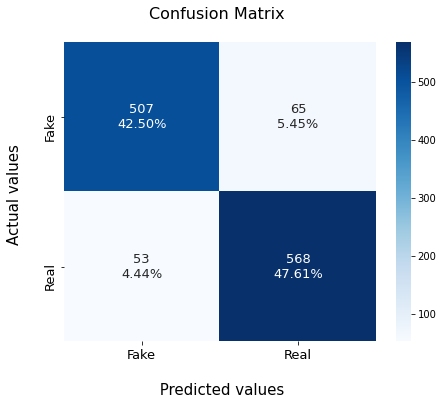

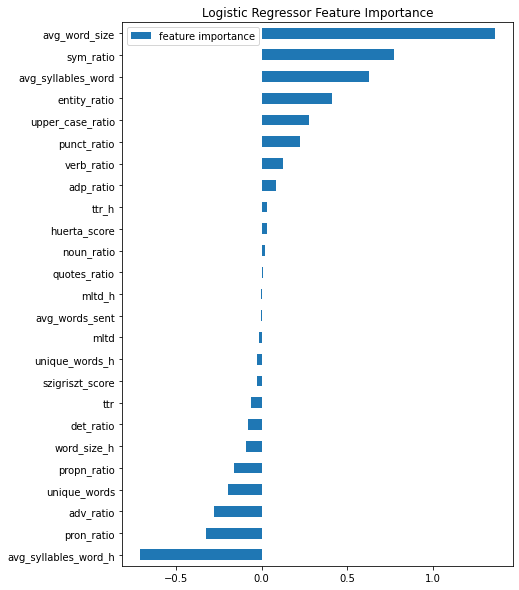

In [92]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, classification_report, log_loss

df = pd.read_csv('../data/spanish_corpus_features_v6.csv')
y = df['label']

########### Training and testing split ########### 

numeric_features = ['word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 
                      'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 
                      'huerta_score', 'szigriszt_score', 'upper_case_ratio', 'entity_ratio', 'quotes_ratio', 'propn_ratio', 
                      'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 'adv_ratio', 
                      'sym_ratio']

X = df[numeric_features]
tfvocab = df[numeric_features].columns.tolist()

# Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


########### Logistic Regression Classifier ########### 

logreg_model = LogisticRegression(max_iter = 2000)
logreg_model.fit(X_train, y_train)


########### Predictions and results ###########

# prediction and results
y_pred = logreg_model.predict(X_test)
probs = logreg_model.predict_proba(X_test)
probs = probs[:, 1]

prediction_results(logreg_model, y_test, X_test, y_pred, probs)

# confusion matrix

plot_confusion_matrix(y_test, y_pred)


########### Feature importance ###########

importance = logreg_model.coef_[0]

df_feature_importance = pd.DataFrame(logreg_model.coef_[0], index = tfvocab, columns = ['feature importance']).sort_values('feature importance', ascending = True)

# plot feature importance

fig, ax = plt.subplots(figsize = [7, 10])
df_feature_importance.plot(kind = 'barh', ax = ax, title = 'Logistic Regressor Feature Importance');

## 2.2 K-Nearest Neighbors Classifier

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    5.8s finished


Best hyperparameters: {'leaf_size': 1, 'n_neighbors': 6, 'p': 1}
Testing AUC score: 0.94
Logloss: 3.97
Accuracy: 88.52


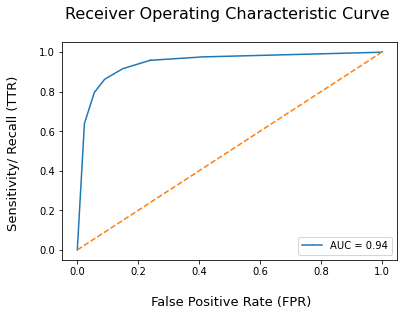

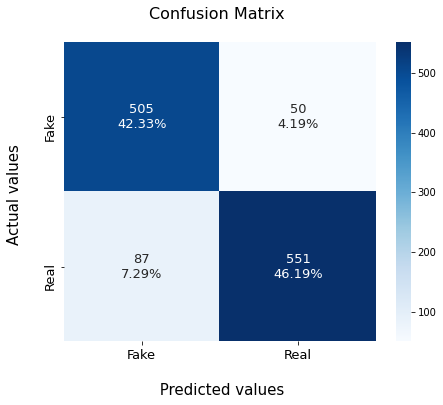

In [93]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, classification_report, log_loss

df = pd.read_csv('../data/spanish_corpus_features_v6.csv')
y = df['label']

########### Numeric features & train, test split ########### 

numeric_features = ['word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 
                    'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 'huerta_score', 
                    'szigriszt_score', 'upper_case_ratio', 'entity_ratio', 'quotes_ratio', 'propn_ratio', 'noun_ratio', 
                    'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 'adv_ratio', 'sym_ratio']

X = df[numeric_features].values
tfvocab = df[numeric_features].columns.tolist()

# training and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

########### K-Nearest Neighbors Classifier ###########

# hyperparameters for the grid search

hyperparameters = {
    'leaf_size': list(range(1, 5)),
    'n_neighbors': list(range(1, 10)),
    'p': [1, 2]
}

# classifier
knn_model = KNeighborsClassifier()

grid_search = GridSearchCV(knn_model, hyperparameters, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

print('Best hyperparameters:' , grid_search.best_params_)
knn_model = grid_search.best_estimator_


########### Predictions and results ###########

# prediction and results
y_pred = knn_model.predict(X_test)
probs = knn_model.predict_proba(X_test)
probs = probs[:, 1]

prediction_results(knn_model, y_test, X_test, y_pred, probs)

# confusion matrix

plot_confusion_matrix(y_test, y_pred)

## 2.4. Random Forest Classifier with GridSearchCV

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  3.1min finished


Best hyperparameters: {'bootstrap': True, 'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
Testing AUC score: 0.98
Logloss: 2.75
Accuracy: 92.04


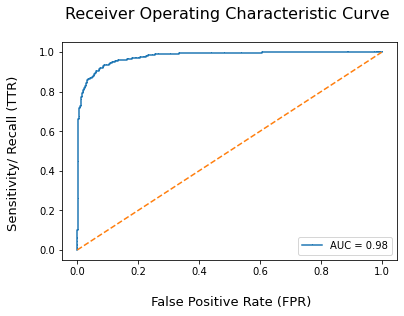

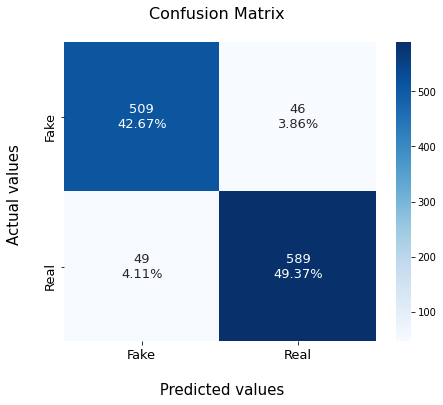

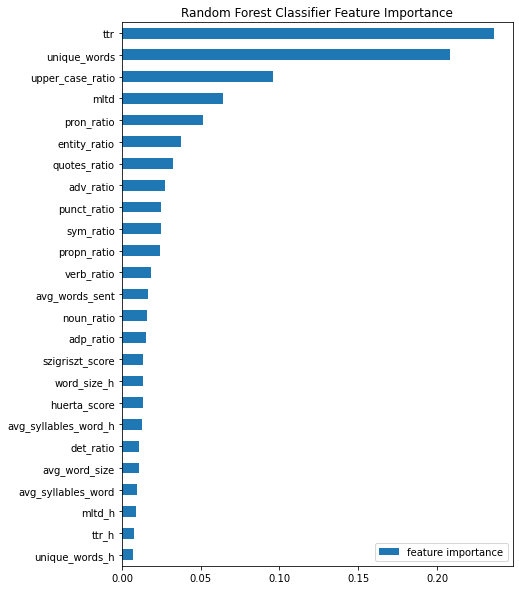

In [94]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, classification_report, log_loss

df = pd.read_csv('../data/spanish_corpus_features_v6.csv')
y = df['label']

########### Features & train, test split ########### 

numeric_features = ['word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 
                    'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 
                    'huerta_score', 'szigriszt_score', 'upper_case_ratio', 'entity_ratio', 'quotes_ratio', 'propn_ratio', 
                    'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 'adv_ratio', 
                    'sym_ratio']

X = df[numeric_features].values
tfvocab = df[numeric_features].columns.tolist()

# Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)


########### Random Forest CLassifier ########### 

# hyperparameters for the grid search

param_grid = {
    'bootstrap': [True],
    'max_depth': [60, 70, 80],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [5, 10],
    'n_estimators': [600, 800, 1000]
}

# classifier

rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

print('Best hyperparameters:' , grid_search.best_params_)
rf_model = grid_search.best_estimator_


########### Predictions and results ###########

# prediction and results
y_pred = rf_model.predict(X_test)
probs = rf_model.predict_proba(X_test)
probs = probs[:, 1]

prediction_results(rf_model, y_test, X_test, y_pred, probs)

# confusion matrix

plot_confusion_matrix(y_test, y_pred)


########### Feature importance ###########

df_feature_importance = pd.DataFrame(rf_model.feature_importances_, index = tfvocab, 
                                     columns = ['feature importance']).sort_values('feature importance')

fig, ax = plt.subplots(figsize = [7, 10])
df_feature_importance.plot(kind = 'barh', ax = ax, title = 'Random Forest Classifier Feature Importance');

# 3. Second approach: TFIDF Transformation + features

## TFIDF Transformation

In [114]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords  
from nltk import word_tokenize  
from nltk.data import load  
from nltk.stem import SnowballStemmer  
from string import punctuation

df = pd.read_csv('../data/spanish_corpus_features_v6.csv')

####### TFIDF Transformation to text ########

#Stopword list to use
spanish_stopwords = stopwords.words('spanish')

#Spanish stemmer:
stemmer = SnowballStemmer('spanish')

def stem_tokens(tokens, stemmer):  
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

#Punctuation to remove
non_words = list(punctuation)

#Adding spanish punctuation
non_words.extend(['¿', '¡', '‘', '’', '“', '”'])  
non_words.extend(map(str, range(10)))

def tokenize(text):  
    #Remove punctuation
    text = ''.join([c for c in text if c not in non_words])
    #Tokenize
    tokens =  word_tokenize(text)

    #Stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems


tfidf_vectorizer = TfidfVectorizer(  
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = spanish_stopwords)

text_vectorized = tfidf_vectorizer.fit_transform(df['text'])

# feature names
tfvocab = tfidf_vectorizer.get_feature_names()

## 3.1. Passive Aggressive Classifier (Only TFIDF features)

Logloss: 2.55
Accuracy: 92.62


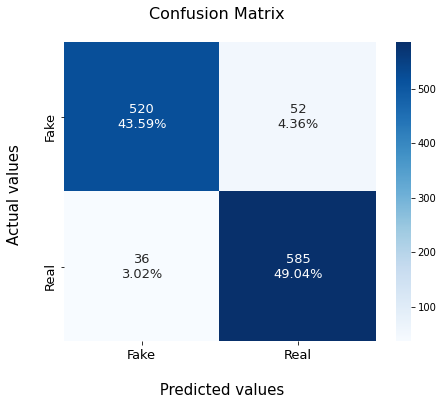

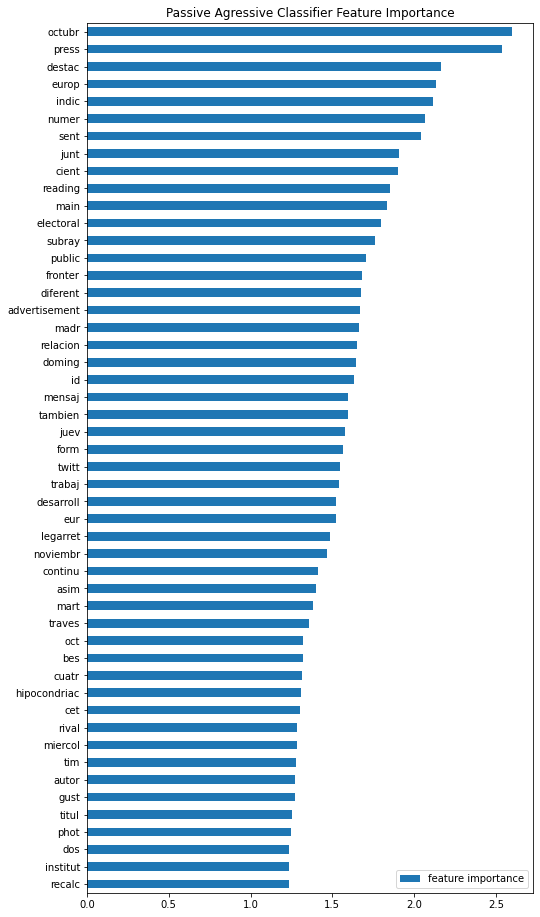

In [100]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy import stats
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, classification_report, log_loss

df = pd.read_csv('../data/spanish_corpus_features_v6.csv')
y = df['label']

########### Train, test split ########### 

X = text_vectorized

# Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


########### Passive Aggressive CLassifier ########### 

pa_model = PassiveAggressiveClassifier(max_iter = 50)


pa_model.fit(X_train, y_train)


########### Predictions and results ###########

# predictions
y_pred = pa_model.predict(X_test)

# accuracy score
print('Logloss: %.2f' % (log_loss(y_test, y_pred)))
print('Accuracy: %.2f' % (pa_model.score(X_test, y_test) * 100))

# confusion matrix

plot_confusion_matrix(y_test, y_pred)


########### Feature importance ###########

importance = pa_model.coef_[0]

df_feature_importance = pd.DataFrame(importance, index = tfvocab, 
                                     columns = ['feature importance']).sort_values('feature importance', ascending = False)
df_feature_importance = df_feature_importance[0:50]
df_feature_importance = df_feature_importance.sort_values(by=['feature importance'])

fig, ax = plt.subplots(figsize = [8, 16])
df_feature_importance.plot(kind = 'barh', ax = ax, title = 'Passive Agressive Classifier Feature Importance');

## 3.2. K-Nearest Neighbours with GridSearchCV

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  1.7min finished


Best hyperparameters: {'leaf_size': 1, 'n_neighbors': 9, 'p': 1}
Testing AUC score: 0.95
Logloss: 3.71
Accuracy: 89.27


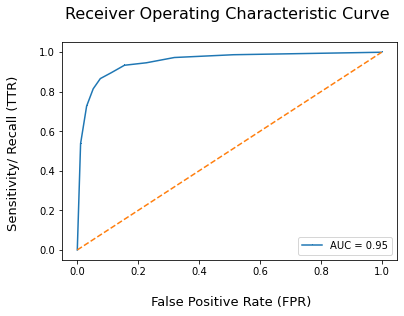

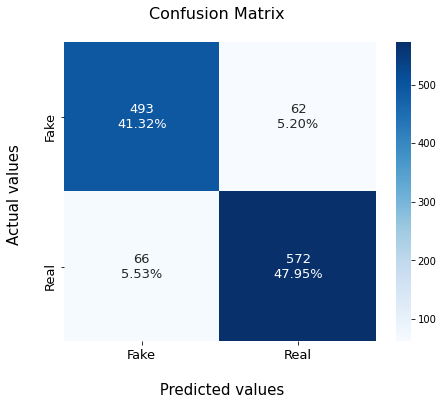

In [102]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, classification_report, log_loss

df = pd.read_csv('../data/spanish_corpus_features_v6.csv')
y = df['label']

########### Numeric features & train, test split ########### 

numeric_features = ['word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 
                    'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 'huerta_score', 
                    'szigriszt_score', 'upper_case_ratio', 'entity_ratio', 'quotes_ratio', 'propn_ratio', 'noun_ratio', 
                    'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 'adv_ratio', 'sym_ratio']

X = hstack([csr_matrix(df[numeric_features].values), text_vectorized[0:]])
tfvocab = df[numeric_features].columns.tolist() + tfvocab

# Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

########### K-Nearest Neighbors Classifier ###########

# hyperparameters for the grid search

hyperparameters = {
    'leaf_size': list(range(1, 5)),
    'n_neighbors': list(range(1, 10)),
    'p': [1, 2]
}

# classifier
knn_model2 = KNeighborsClassifier()

grid_search = GridSearchCV(knn_model, hyperparameters, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

print('Best hyperparameters:' , grid_search.best_params_)
knn_model = grid_search.best_estimator_


########### Predictions and results ###########

# prediction and results
y_pred = knn_model2.predict(X_test)
probs = knn_model2.predict_proba(X_test)
probs = probs[:, 1]

prediction_results(knn_model2, y_test, X_test, y_pred, probs)

# confusion matrix

plot_confusion_matrix(y_test, y_pred)

## 3.4. Random Forest Classifier with GridSearchCV

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  9.4min finished


{'bootstrap': True, 'max_depth': 60, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
Testing AUC score: 0.99
Logloss: 2.26
Accuracy: 93.46


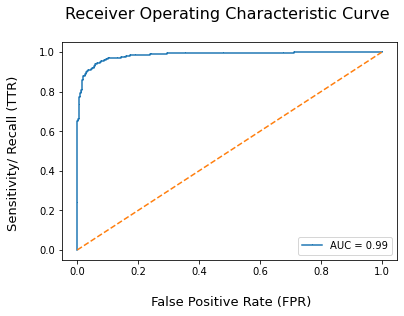

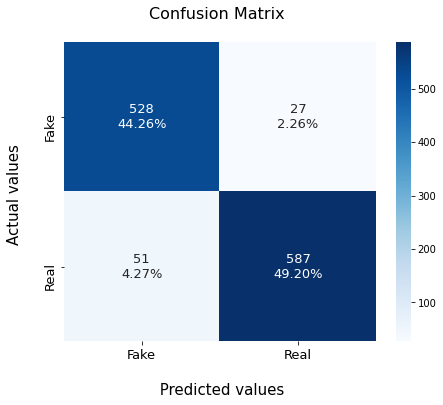

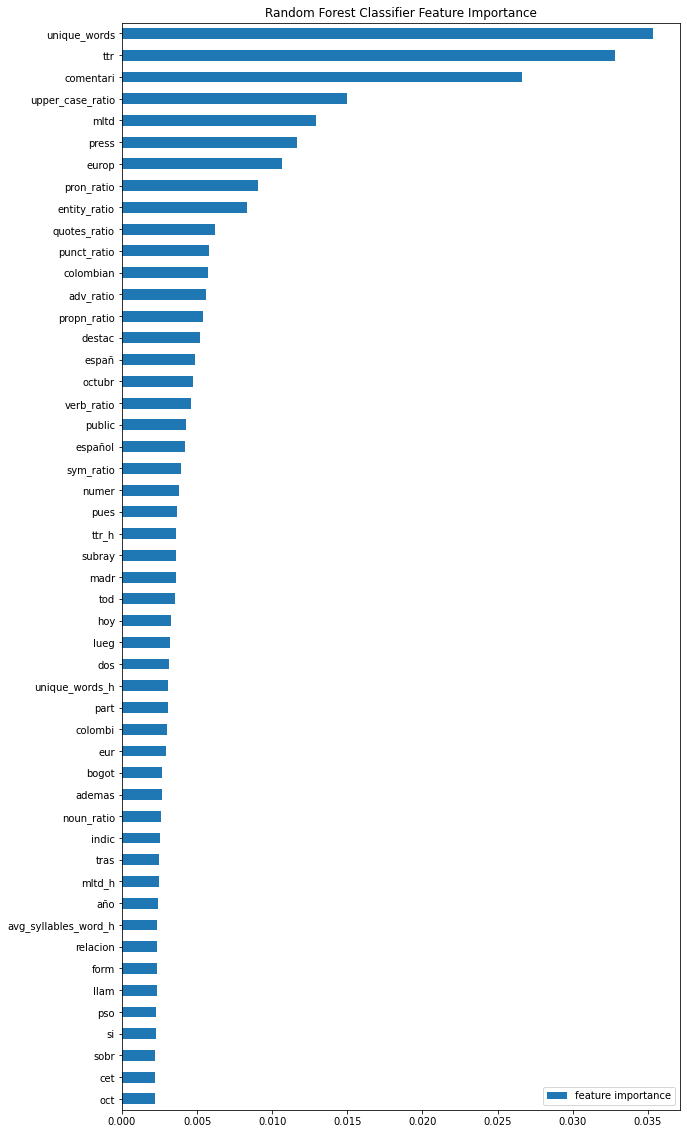

In [115]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy.sparse import hstack, csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, classification_report, log_loss

df = pd.read_csv('../data/spanish_corpus_features_v6.csv')
y = df['label']


########### Combine Features & train, test split ########### 

numeric_features = ['word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 
                    'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 
                    'huerta_score', 'szigriszt_score', 'upper_case_ratio', 'entity_ratio', 'quotes_ratio', 'propn_ratio', 
                    'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 'adv_ratio', 
                    'sym_ratio']

X = hstack([csr_matrix(df[numeric_features].values), text_vectorized[0:]])
feature_names = df[numeric_features].columns.tolist() + tfvocab

# Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)


########### Random Forest CLassifier ########### 

param_grid = {
    'bootstrap': [True],
    'max_depth': [60, 70, 80],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [5, 10],
    'n_estimators': [600, 800, 1000]
}

rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
rf_model2 = grid_search.best_estimator_


########### Predictions and results ###########

# predictions
y_pred = rf_model2.predict(X_test)
probs = rf_model2.predict_proba(X_test)
probs = probs[:, 1]

# prediction and results
y_pred = rf_model2.predict(X_test)
probs = rf_model2.predict_proba(X_test)
probs = probs[:, 1]

prediction_results(rf_model2, y_test, X_test, y_pred, probs)

# confusion matrix

plot_confusion_matrix(y_test, y_pred)


########### Feature importance ###########

# feature importance with default names

df_feature_importance = pd.DataFrame(rf_model2.feature_importances_, index = feature_names, 
                                     columns = ['feature importance']).sort_values('feature importance', ascending = False)
df_feature_importance = df_feature_importance[0:50]
df_feature_importance = df_feature_importance.sort_values(by=['feature importance'])

fig, ax = plt.subplots(figsize = [10, 20])
df_feature_importance.plot(kind = 'barh', ax = ax, title = 'Random Forest Classifier Feature Importance');